# Seismic Signal Preprocessing with ObsPy

This notebook introduces the structure of miniSEED files and demonstrates how to read, preprocess, and visualize seismic waveforms using the ObsPy library in Python. We will cover:

1. **miniSEED Structure**: Overview of how seismic traces are organized in miniSEED files.
2. **Reading Data**: Loading miniSEED files into ObsPy Stream and Trace objects.
3. **Preprocessing Steps**:
   - Merging and cleaning streams
   - Detrending and tapering
   - Filtering (bandpass) and decimation
   - Trimming (slicing) data by time window
4. **Visualization**:
   - Time-domain plots
   - Frequency-domain analysis (FFT and Welch PSD)

## 1. Understanding miniSEED Files & Metadata

miniSEED is a compact, binary format standardized by the FDSN (Federation of Digital Seismograph Networks) for storing seismic waveform data. Each miniSEED **Record** contains a fixed-size header followed by binary samples. In ObsPy, a collection of Records is represented as a **Stream** (a list of **Trace** objects), where each Trace corresponds to a continuous segment of data for a specific channel.

Key metadata fields available in `Trace.stats`:

- **network**: Network code (e.g., 'IU', 'US'), identifies the seismic network.  
- **station**: Station code (e.g., 'ANMO'), labels the recording site.  
- **location**: Location code (e.g., '00', '10'), used to distinguish multiple sensors or deployments at the same station.  
- **channel**: Channel code (e.g., 'BHZ', 'HHZ'), encodes instrument type and component:
  - First character: bandwidth ('B' = broad band, 'H' = high sampling rate, etc.)
  - Second character: instrument family (e.g., 'H' = high gain seismometer)
  - Third character: component (e.g., 'Z' = vertical, 'N' = north–south, 'E' = east–west)
- **id**: Combined identifier in the format `network.station.location.channel` (e.g., 'IU.ANMO.00.BHZ').
- **starttime** / **endtime**: `UTCDateTime` objects marking the timestamps of the first and last samples.  
- **sampling_rate**: Number of samples per second (Hz).  
- **delta**: Time interval between samples (seconds), equal to `1 / sampling_rate`.  
- **npts**: Total number of data points in the Trace.  
- **mseed**: (Optional) Raw miniSEED-specific information accessible if loaded with `format='MSEED'`.  
- **processing**: List of text entries summarizing any processing steps already applied to the data.

You can inspect these fields for any Trace:

```python
from obspy import read

st = read("path/to/your_file.mseed", format="MSEED")
tr = st[0]
print(f"ID: {tr.id}")
for key, value in tr.stats.items():
    print(f"{key}: {value}")
```


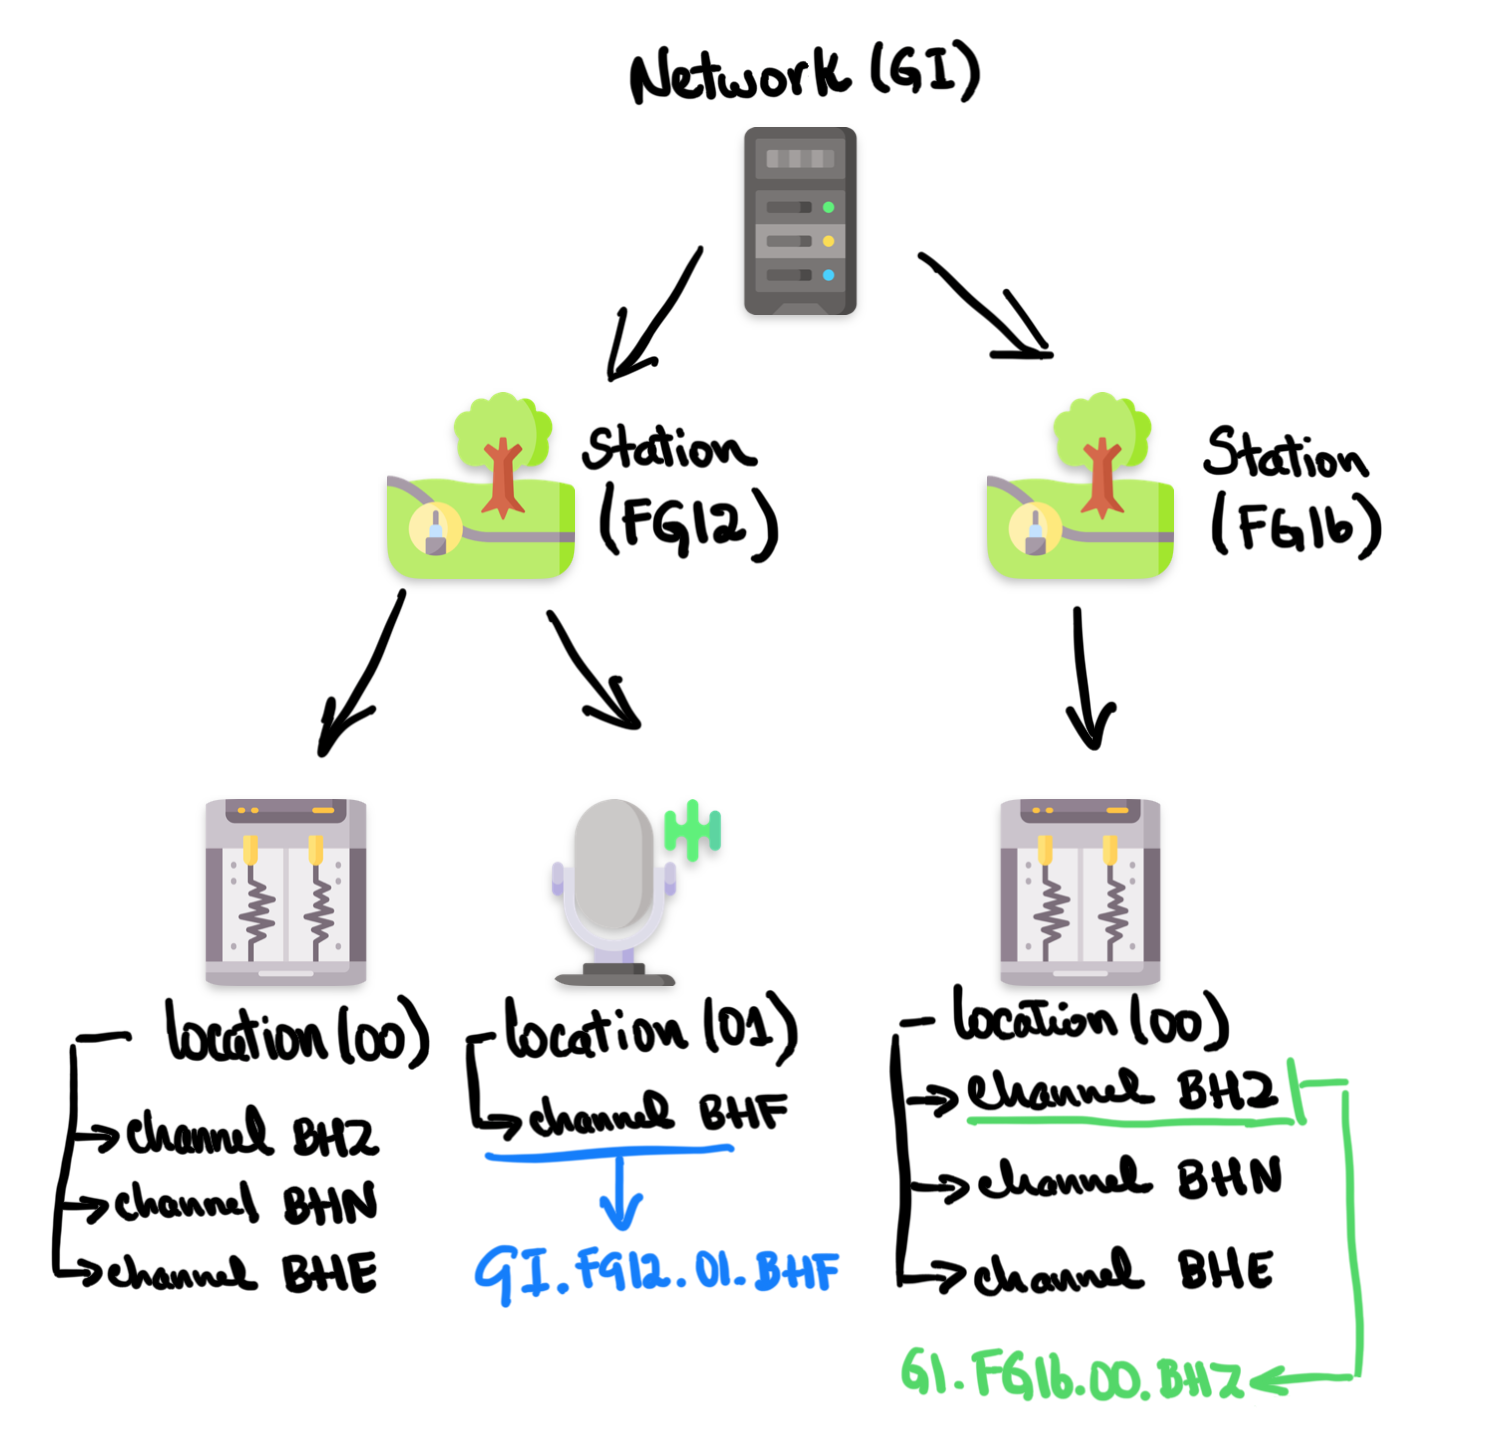

In [1]:
from obspy import read

st = read('/Users/gustavo/Library/CloudStorage/GoogleDrive-gbejarlo@mtu.edu/Shared drives/Lahar Project at Yachay/Data/Seismic/6Q.FGLR..HHZ.2021.176.mseed', format="MSEED")
tr = st[0]
print(f"ID: {tr.id}")
for key, value in tr.stats.items():
    print(f"{key}: {value}")

ID: XX.FGLR..HHZ
sampling_rate: 125.0
delta: 0.008
starttime: 2021-06-25T00:00:00.000000Z
endtime: 2021-06-25T23:59:59.992000Z
npts: 10800000
calib: 1.0
network: XX
station: FGLR
location: 
channel: HHZ
mseed: AttribDict({'dataquality': 'D', 'number_of_records': 4686, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 4096, 'filesize': 19193856})
_format: MSEED


## 2. Reading miniSEED Data in Python

```python
# Import ObsPy
from obspy import read

# Read a miniSEED file into a Stream object
nstream = read("path/to/your_file.mseed")

# Inspect the Stream
print(nstream)
# See details of each Trace
for tr in nstream:
    print(tr.id, tr.stats.starttime, tr.stats.sampling_rate, tr.stats.npts)
```

## 3. Preprocessing Steps

### 3.1 Merging and Cleaning Streams

miniSEED files often contain gaps (missing data) or overlaps (duplicated time ranges) due to recording or transmission issues. This can result in inconsistencies when analyzing or visualizing data. 

Merging helps consolidate multiple traces from the same channel into a single continuous Trace object. You can choose how to handle gaps (e.g., interpolate, pad with zeros, or fill with NaNs).

```python
# Merge gaps with linear interpolation and pad with zeros if needed
nstream.merge(method=1, fill_value=0)
```

### 3.2 Detrending and Tapering

Detrending removes low-frequency linear trends in the data that may be caused by instrument drift, temperature changes, or long-term baseline shifts. These trends can obscure the signals of interest, especially in spectral analysis.

Tapering applies a windowing function (e.g., Hann window) to reduce edge effects when filtering or transforming signals. Sharp edges can introduce artificial high-frequency components.

```python
for tr in nstream:
    tr.detrend(type='linear')  # Remove linear trend
    tr.taper(type='hann', max_percentage=0.05)  # Smooth edges with taper
```

### 3.3 Filtering and Decimation

Bandpass filtering isolates the frequency band relevant to your study (e.g., 0.5–20 Hz for lahars or local earthquakes). It removes both low-frequency noise (e.g., tidal or temperature-related drift) and high-frequency noise (e.g., electronic or environmental interference).

Decimation reduces the sampling rate by keeping every Nth sample. This is useful when the original data is oversampled for your target frequency band. It makes processing faster and reduces storage requirements. Always filter before decimation to avoid aliasing.

```python
# Bandpass between 0.5 and 20 Hz
nstream.filter('bandpass', freqmin=0.5, freqmax=20.0, corners=4, zerophase=True)

# Downsample data if needed
for tr in nstream:
    tr.decimate(factor=2, strict_length=False)
```

### 3.4 Trimming / Slicing Data

Trimming extracts a specific time window from each trace. This is important for focusing on events of interest (e.g., a known lahar or earthquake) and avoiding unrelated data. It simplifies analysis and visualization by reducing the dataset to relevant time intervals.

```python
from obspy import UTCDateTime
start = UTCDateTime("2021-01-01T00:00:00")
end = start + 300  # 5-minute window
nstre
```  

## 4. Nyquist Frequency

The **Nyquist frequency** is half the sampling rate (fs/2) and defines the maximum frequency that can be accurately represented without aliasing. Per the Nyquist–Shannon sampling theorem, you must sample at **at least twice** the highest signal frequency (fₘₐₓ) to reconstruct the waveform correctly.

- **fs = 2·f₀** (Nyquist limit): captures exactly one sample at each peak and trough, allowing accurate reconstruction.  
- **fs < 2·f₀**: frequencies above fs/2 fold back (alias) into lower frequencies, distorting the reconstructed signal.  
- **fs > 2·f₀**: oversampling yields more data points (reducing quantization noise, easing filter design) but adds no new information about the signal’s true frequency content.

```python
# Report sampling rate and Nyquist frequency
for tr in nstream:
    fs = tr.stats.sampling_rate
    print(f"Sampling rate: {fs} Hz → Nyquist frequency: {fs/2} Hz")
```

![Nyquist1](https://miro.medium.com/v2/format:webp/1*BnZAWV4OIwyJhX1gNrojPw.png)

![Nyquist2](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*UHmv34t5wZYP3ysAmIKo5A.png)

![Nyquist3](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*zqIy-KoX_E-NCPv3cFdrlA.png)

## 4. Visualization

### 4.1 Time-Domain Plot

```python
stream.plot(equal_scale=True, size=(800, 300))
```

### 4.2 Frequency-Domain Analysis

Analyzing the frequency domain reveals how signal energy distributes across frequencies. The **Fast Fourier Transform (FFT)** converts a time-series into discrete frequency components, highlighting dominant periodicities and noise characteristics. The raw FFT can be noisy, so **Welch’s PSD** uses segmenting and averaging to produce smoother spectra.

Key points:
- **Spectral Leakage**: mitigated by tapering before FFT.
- **Frequency Resolution (Δf)**: Δf = 1/T, where T is the data length.
- **Variance–Resolution Trade-off**: Welch’s method reduces variance at the cost of resolution.
- **Log–Log Plotting**: reveals patterns across wide dynamic ranges.

```python
import matplotlib.pyplot as plt
from obspy.signal import PPSD
import numpy as np

# Manual FFT
tr = stream[0]
fs = tr.stats.sampling_rate
npts = tr.stats.npts
dt = tr.stats.delta
freqs = np.fft.rfftfreq(npts, dt)
windowed = tr.data * np.hanning(npts)
psd_fft = np.abs(np.fft.rfft(windowed))**2 / (fs * npts)

plt.figure(figsize=(8,4))
plt.loglog(freqs, psd_fft)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('FFT Spectrum')
plt.grid(True)
plt.show()

# Welch PSD with ObsPy
ppsd = PPSD(tr.stats, metadata={})
ppsd.add(tr)
ppsd.plot()
```

### 4.3 Spectrogram

Spectrograms show how the signal's frequency content evolves over time by computing a short-time Fourier transform (STFT). They are especially useful for nonstationary signals (e.g., seismic events).

```python
# Spectrogram using ObsPy built-in method
tr = stream[0]
tr.spectrogram(
    log=True,        # use logarithmic amplitude scaling
    dbscale=True,    # convert amplitude to decibels
    wlen=2.0,        # window length in seconds
    title='Spectrogram (dB)'
)
```  